<a href="https://colab.research.google.com/github/hellocybernetics/TensorFlow_Eager_Execution_Tutorials/blob/master/tutorials/99_others/hyper_parameter_optimization_using_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

    100% |████████████████████████████████| 61kB 4.2MB/s 
    100% |████████████████████████████████| 5.7MB 5.3MB/s 
    100% |████████████████████████████████| 81kB 22.0MB/s 
    100% |████████████████████████████████| 112kB 30.7MB/s 
    100% |████████████████████████████████| 51kB 18.8MB/s 
    100% |████████████████████████████████| 92kB 27.0MB/s 
  Running setup.py bdist_wheel for optuna ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ec/1e/a0/053e87d09e20ca1cd0838fb90789bd7b1439cffd17d5cfd059
  Running setup.py bdist_wheel for sqlalchemy ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/86/c8/99/8d6049a373070743a79ada4cf9798f8130cc8e2dfcd66e0e9d
  Running setup.py bdist_wheel for PrettyTable ... - done
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Running setup.py bdist_wheel for pyperclip ... - done
  Stored in directory: /root/.cache/pip/wheels/92/f0/ac/2ba29

In [0]:
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
%matplotlib inline

## Simple Practice
### objective function

$$
f(x) = 2x^4 + 2x^3 - 2x^2
$$

We will find the minimum value of $f(x^*)$ and $x^*$ using optuna which is provided Prefferd Networks.

### graph of $f(x)$

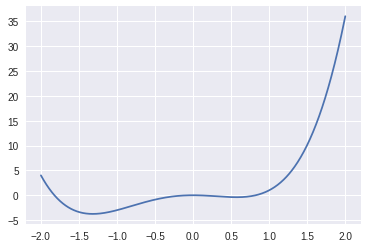

In [15]:
x = np.linspace(-2, 2, 1000)
plt.plot(x, 2*x**4 + 2*x**3 - 3*x**2)

### optimization

In [0]:
def objective(trial):
    trial.suggest_uniform('x', -2, 2)
    f = x**4 + 2*x**3 - 2*x**2
    return f

In [16]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[W 2018-12-03 10:01:28,207] Setting trial status as TrialState.FAIL because the returned value from the objective function cannot be casted to float. Returned value is: array([-8.00000000e+00, -7.99984006e+00, -7.99936180e+00, -7.99856749e+00,
       -7.99745946e+00, -7.99603997e+00, -7.99431132e+00, -7.99227579e+00,
       -7.98993564e+00, -7.98729313e+00, -7.98435054e+00, -7.98111010e+00,
       -7.97757407e+00, -7.97374468e+00, -7.96962418e+00, -7.96521478e+00,
       -7.96051870e+00, -7.95553818e+00, -7.95027540e+00, -7.94473258e+00,
       -7.93891192e+00, -7.93281560e+00, -7.92644580e+00, -7.91980471e+00,
       -7.91289450e+00, -7.90571733e+00, -7.89827537e+00, -7.89057077e+00,
       -7.88260567e+00, -7.87438221e+00, -7.86590254e+00, -7.85716878e+00,
       -7.84818305e+00, -7.83894747e+00, -7.82946416e+00, -7.81973520e+00,
       -7.80976271e+00, -7.79954877e+00, -7.78909548e+00, -7.77840490e+00,
       -7.76747912e+00, -7.75632020e+00, -7.74493020e+00, -7.73331117e+00,
      

In [0]:
N_TRAIN_EXAMPLES = 3000
N_TEST_EXAMPLES = 1000
BATCHSIZE = 128
EPOCH = 10


def create_model(trial):
    # We optimize the numbers of layers and their units.
    n_layers = trial.suggest_int('n_layers', 1, 3)

    layers = []
    for i in range(n_layers):
        n_units = int(trial.suggest_loguniform('n_units_l{}'.format(i), 4, 128))
        layers.append(L.Linear(None, n_units))
        layers.append(F.relu)
    layers.append(L.Linear(None, 10))

    return chainer.Sequential(*layers)


def create_optimizer(trial, model):
    # We optimize the choice of optimizers as well as their parameters.
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'MomentumSGD'])
    if optimizer_name == 'Adam':
        adam_alpha = trial.suggest_loguniform('adam_alpha', 1e-5, 1e-1)
        optimizer = chainer.optimizers.Adam(alpha=adam_alpha)
    else:
        momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
        optimizer = chainer.optimizers.MomentumSGD(lr=momentum_sgd_lr)

    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer.WeightDecay(weight_decay))
    return optimizer


def objective(trial):
    # Model and optimizer
    model = L.Classifier(create_model(trial))
    optimizer = create_optimizer(trial, model)

    # Dataset
    rng = np.random.RandomState(0)
    train, test = chainer.datasets.get_mnist()
    train = chainer.datasets.SubDataset(
        train, 0, N_TRAIN_EXAMPLES, order=rng.permutation(len(train)))
    test = chainer.datasets.SubDataset(
        test, 0, N_TEST_EXAMPLES, order=rng.permutation(len(test)))
    train_iter = chainer.iterators.SerialIterator(train, BATCHSIZE)
    test_iter = chainer.iterators.SerialIterator(test, BATCHSIZE, repeat=False, shuffle=False)

    # Trainer
    updater = chainer.training.StandardUpdater(train_iter, optimizer)
    trainer = chainer.training.Trainer(updater, (EPOCH, 'epoch'))
    trainer.extend(chainer.training.extensions.Evaluator(test_iter, model))
    log_report_extension = chainer.training.extensions.LogReport(log_name=None)
    trainer.extend(chainer.training.extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy']))
    trainer.extend(log_report_extension)

    # Run!
    trainer.run()

    # Set the user attributes such as loss and accuracy for train and validation sets
    log_last = log_report_extension.log[-1]
    for key, value in log_last.items():
        trial.set_user_attr(key, value)

    # Return the validation error
    val_err = 1.0 - log_report_extension.log[-1]['validation/main/accuracy']
    return val_err


if __name__ == '__main__':
    import optuna
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)

    print('Number of finished trials: ', len(study.trials))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: ', trial.value)

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    print('  User attrs:')
    for key, value in trial.user_attrs.items():
        print('    {}: {}'.format(key, value))